# Bias Frames Analysis Notebook

Analyze bias images. A few things we're looking for in the next few cell blocks are the following: 1) "Bright Bias" oddities, where for some reason bias frames (1 us dark exposures) tend to be brighter than longer exposures. 2) "Even/Odd Row Patterns," where even rows have systematically different bias levels than odd rows 3) Bias frame stability over multiple days and after mode-switching

Load dependencies.

In [1]:
# Make sure that any changes to the dependencies are automatically updated
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
# Tools for opening image stacks and relevant data from fits headers
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict
# Tools for making defect pixel histograms
from defect_pixel_funcs import *
from scipy.optimize import curve_fit

Load the relevant bias and short-duration dark images.

In [2]:
# The folder in which bias image stacks are stored.
bias_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Bias Images/HS_HG_GS/9-28-24'
# Load the image stacks. Each element of bias_stacks is a dictionary containing relevant header data and the mean image.
# I don't load all of the frames in the image stacks here to save memory.
bias_stacks = get_stacks(bias_folder, num_imgs=0, get_mean_img=True, get_var_img=False)


Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Bias Images/HS_HG_GS/9-28-24/HSHG_GS_dark_1000ms_-25C 2024-09-28 23_00_30.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Bias Images/HS_HG_GS/9-28-24/HSHG_GS_dark_120000ms_-25C 2024-09-28 23_31_01.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Bias Images/HS_HG_GS/9-28-24/HSHG_GS_dark_10000ms_-25C 2024-09-28 23_05_51.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Bias Images/HS_HG_GS/9-28-24/HSHG_GS_dark_1us_-25C 2024-09-28 22_59_56.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/

In [3]:
# Sort bias_stacks by exposure time
bias_stacks = sorted(bias_stacks, key=lambda x: float(x["exposure_ms"]))
exp_times = np.array([float(x["exposure_ms"]) for x in bias_stacks])
print("Exposure Times (ms): ", exp_times)

Exposure Times (ms):  [1.0e-03 1.0e+03 5.0e+03 1.0e+04 3.0e+04 6.0e+04 1.2e+05 6.0e+05]


Let's visually inspect the bias and 1 second dark frames. Ideally, by subtracting the bias frame, we should be left with a clean image with an average value of zero.

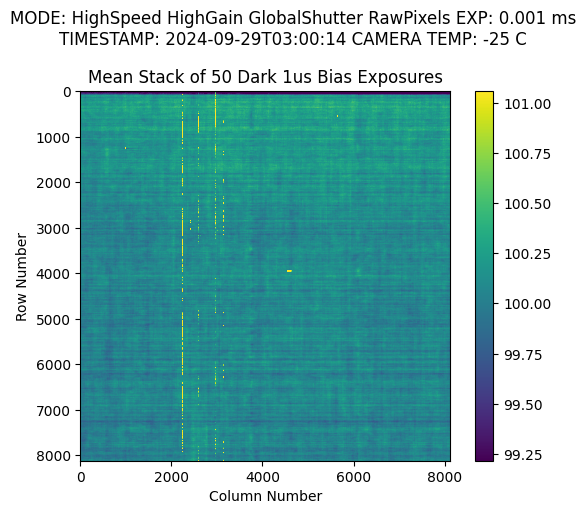

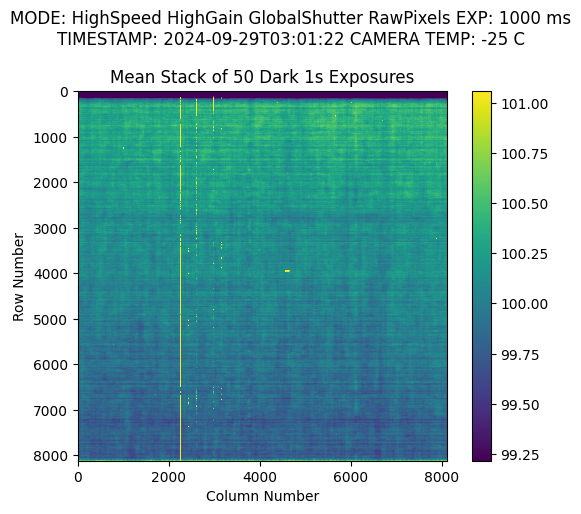

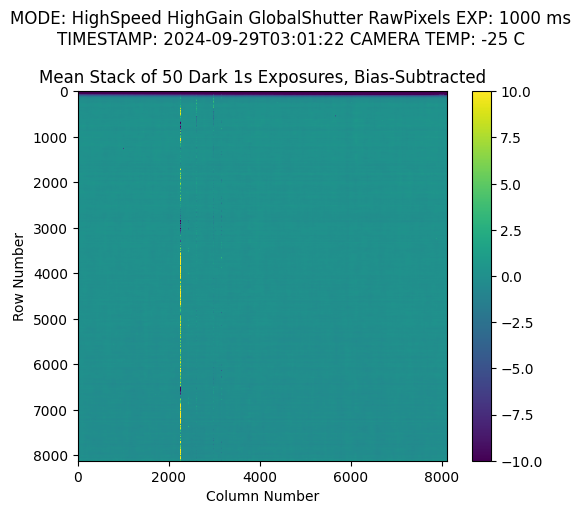

In [4]:
# Set some bounds for the colorbars
bias_low = np.percentile(bias_stacks[0]["mean_img"], 1)
bias_high = np.percentile(bias_stacks[0]["mean_img"], 99)
# Show the raw bias frame
plt.imshow(bias_stacks[0]["mean_img"], vmin=bias_low, vmax=bias_high)
# Label the plot with relevant camera information
label_plot(bias_stacks[0])
plt.colorbar()
plt.title('Mean Stack of 50 Dark 1us Bias Exposures')
plt.xlabel('Column Number')
plt.ylabel('Row Number')
plt.show()

# Show the raw 1s dark frame
plt.imshow(bias_stacks[1]["mean_img"], vmin=bias_low, vmax=bias_high)
label_plot(bias_stacks[1])
plt.colorbar()
plt.title('Mean Stack of 50 Dark 1s Exposures')
plt.xlabel('Column Number')
plt.ylabel('Row Number')
plt.show()

# Show the bias-subtracted 1s dark frame
mean_1s_subtract = bias_stacks[1]["mean_img"] - bias_stacks[0]["mean_img"]
bias_subtract_low = -10
bias_subtract_high = 10
plt.imshow(mean_1s_subtract, vmin=bias_subtract_low, vmax=bias_subtract_high)
label_plot(bias_stacks[1])
plt.colorbar()
plt.title('Mean Stack of 50 Dark 1s Exposures, Bias-Subtracted')
plt.xlabel('Column Number')
plt.ylabel('Row Number')
plt.show()

Plot histograms for the bias-subtracted 1s frame.

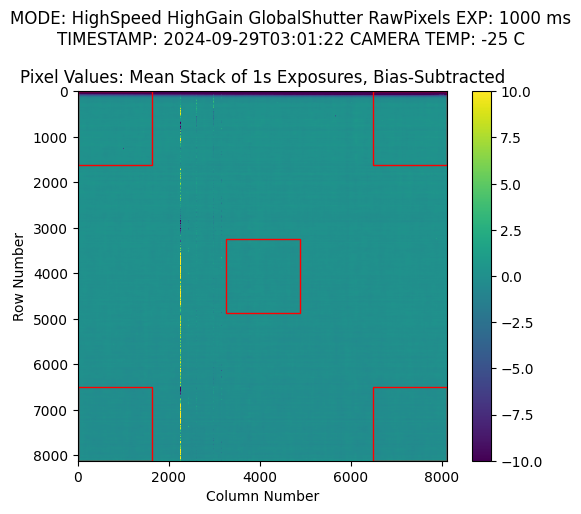

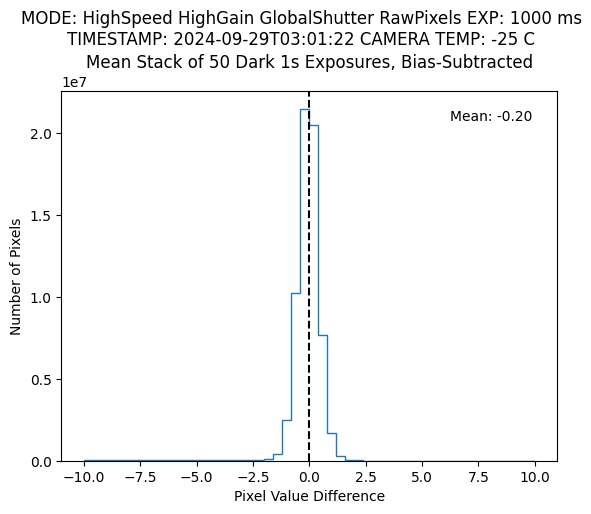

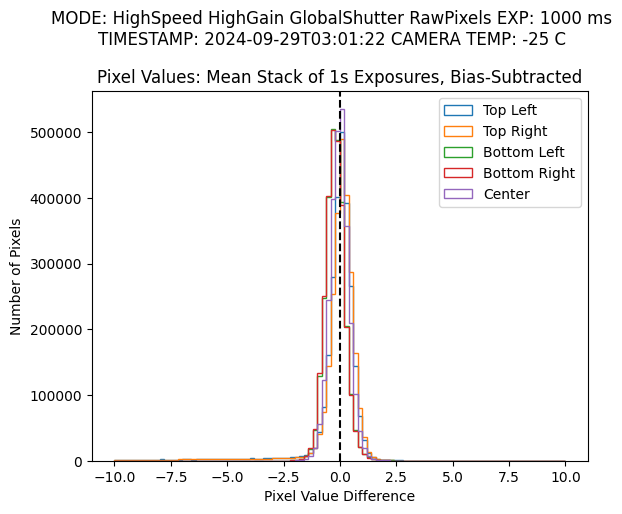

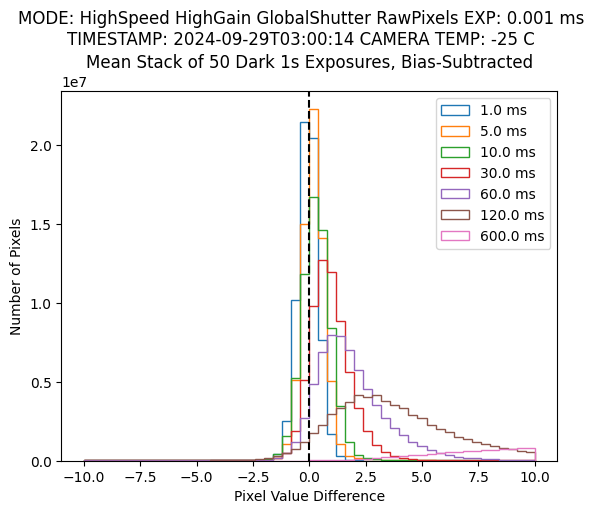

In [5]:
plt.imshow(mean_1s_subtract, vmin=bias_subtract_low, vmax=bias_subtract_high)
plt.colorbar()
label_plot(bias_stacks[1])
plt.title('Pixel Values: Mean Stack of 1s Exposures, Bias-Subtracted')
# Put a box around top left corner
plt.gca().add_patch(plt.Rectangle((0, 0), 1624, 1624, fill=False, edgecolor='red'))
plt.gca().add_patch(plt.Rectangle((6496, 0), 1624, 1624, fill=False, edgecolor='red'))
plt.gca().add_patch(plt.Rectangle((0, 6496), 1624, 1624, fill=False, edgecolor='red'))
plt.gca().add_patch(plt.Rectangle((6496, 6496), 1624, 1624, fill=False, edgecolor='red'))
plt.gca().add_patch(plt.Rectangle((3248, 3248), 1624, 1624, fill=False, edgecolor='red'))
plt.xlabel('Column Number')
plt.ylabel('Row Number')
plt.show()

# Plot a histogram of the bias-subtracted pixel values. If the bias subtraction is working as intended,
# this should be a Gaussian centered at 0.
plt.hist(mean_1s_subtract.flatten(), bins=50, range=(bias_subtract_low, bias_subtract_high), histtype='step')
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel('Pixel Value Difference')
plt.ylabel('Number of Pixels')
label_plot(bias_stacks[1])
plt.title('Mean Stack of 50 Dark 1s Exposures, Bias-Subtracted')
# Add mean value in top right corner
plt.text(0.95, 0.95, 'Mean: {:.2f}'.format(np.mean(bias_stacks[1]["mean_img"] - bias_stacks[0]["mean_img"])), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
plt.show()

# See if different regions of the sensor have different bias-subtracted behavior
mean_1s_subtract_top_left = mean_1s_subtract[:1624, :1624]
mean_1s_subtract_top_right = mean_1s_subtract[:1624, 6496:]
mean_1s_subtract_bottom_left = mean_1s_subtract[6496:, :1624]
mean_1s_subtract_bottom_right = mean_1s_subtract[6496:, 6496:]
mean_1s_subtract_center = mean_1s_subtract[3248:4872, 3248:4872]
plt.hist(mean_1s_subtract_top_left.flatten(), bins=100, range=(bias_subtract_low, bias_subtract_high), histtype='step', label='Top Left')
plt.hist(mean_1s_subtract_top_right.flatten(), bins=100, range=(bias_subtract_low, bias_subtract_high), histtype='step', label='Top Right')
plt.hist(mean_1s_subtract_bottom_left.flatten(), bins=100, range=(bias_subtract_low, bias_subtract_high), histtype='step', label='Bottom Left')
plt.hist(mean_1s_subtract_bottom_right.flatten(), bins=100, range=(bias_subtract_low, bias_subtract_high), histtype='step', label='Bottom Right')
plt.hist(mean_1s_subtract_center.flatten(), bins=100, range=(bias_subtract_low, bias_subtract_high), histtype='step', label='Center')
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel('Pixel Value Difference')
plt.ylabel('Number of Pixels')
label_plot(bias_stacks[1])
plt.legend()
plt.title('Pixel Values: Mean Stack of 1s Exposures, Bias-Subtracted')
plt.show()

# Plot a histogram of the bias-subtracted pixel values for all exposure times.
for i, stack in enumerate(bias_stacks[1:]):
    mean_subtract = stack["mean_img"] - bias_stacks[0]["mean_img"]
    plt.hist(mean_subtract.flatten(), bins=50, range=(bias_subtract_low, bias_subtract_high),
             histtype='step', label='{} ms'.format(exp_times[i+1]/1000))
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel('Pixel Value Difference')
plt.ylabel('Number of Pixels')
plt.legend()
label_plot(bias_stacks[0])
plt.title('Mean Stack of 50 Dark 1s Exposures, Bias-Subtracted')
plt.show()

Check for any row-to-row variations, which can be indicative of different bias levels on different readout channels. We observed this behavior in the spring with rolling shutter modes.

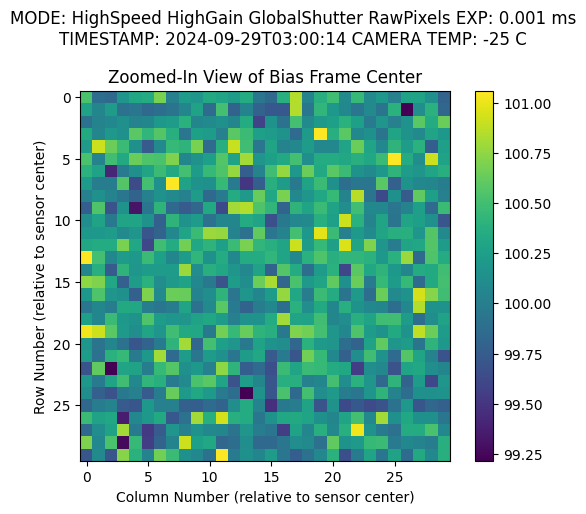

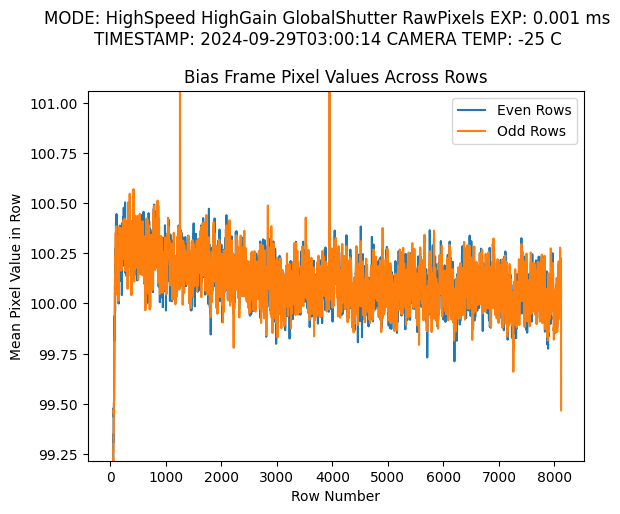

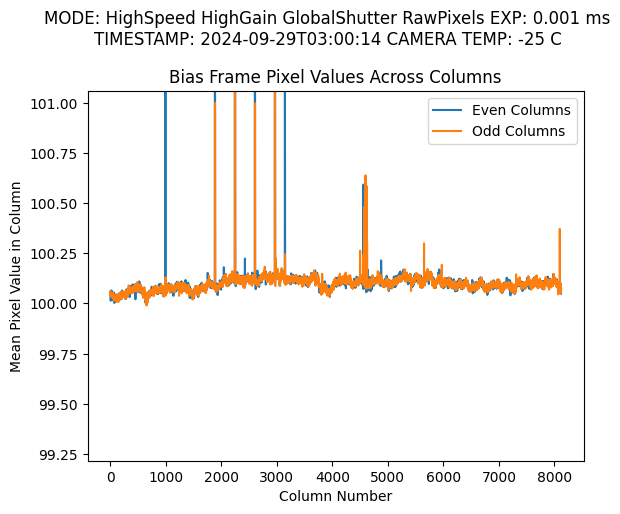

In [6]:
# Plot just the center 10 rows and center 50 columns in the bias frame
plt.imshow(bias_stacks[0]["mean_img"][4060:4090, 4060:4090], vmin=bias_low, vmax=bias_high)
plt.xlabel('Column Number (relative to sensor center)')
plt.ylabel('Row Number (relative to sensor center)')
plt.colorbar()
label_plot(bias_stacks[0])
plt.title('Zoomed-In View of Bias Frame Center')
plt.show()

even_rows_bias = np.mean(bias_stacks[0]["mean_img"][::2], axis=1)
odd_rows_bias = np.mean(bias_stacks[0]["mean_img"][1::2], axis=1)
even_cols_bias = np.mean(bias_stacks[0]["mean_img"][:, ::2], axis=0)
odd_cols_bias = np.mean(bias_stacks[0]["mean_img"][:, 1::2], axis=0)
plt.plot(np.arange(0, 8120, 2), even_rows_bias, label='Even Rows')
plt.plot(np.arange(1, 8120, 2), odd_rows_bias, label='Odd Rows')
plt.xlabel('Row Number')
plt.ylabel('Mean Pixel Value in Row')
plt.ylim(bias_low, bias_high)
label_plot(bias_stacks[0])
plt.legend()
plt.title('Bias Frame Pixel Values Across Rows')
plt.show()

plt.plot(np.arange(0, 8120, 2), even_cols_bias, label='Even Columns')
plt.plot(np.arange(1, 8120, 2), odd_cols_bias, label='Odd Columns')
plt.xlabel('Column Number')
plt.ylabel('Mean Pixel Value in Column')
plt.ylim(bias_low, bias_high)
label_plot(bias_stacks[0])
plt.legend()
plt.title('Bias Frame Pixel Values Across Columns')
plt.show()


Look at alternating row behavior for different exposure times.

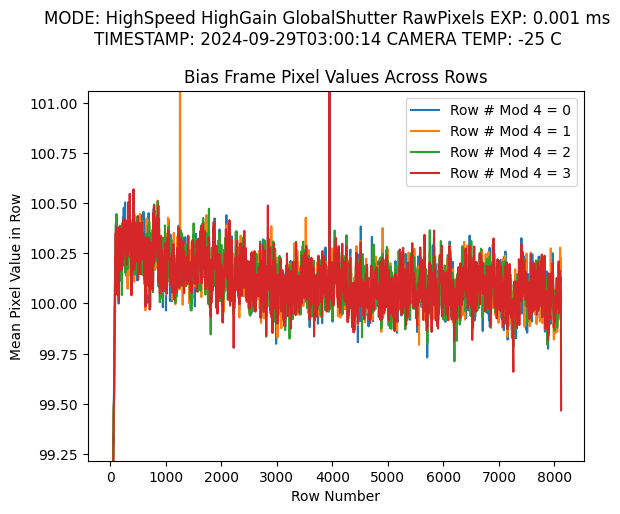

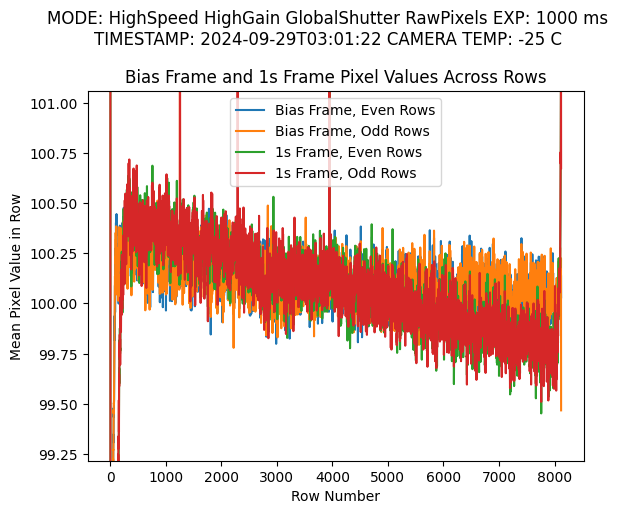

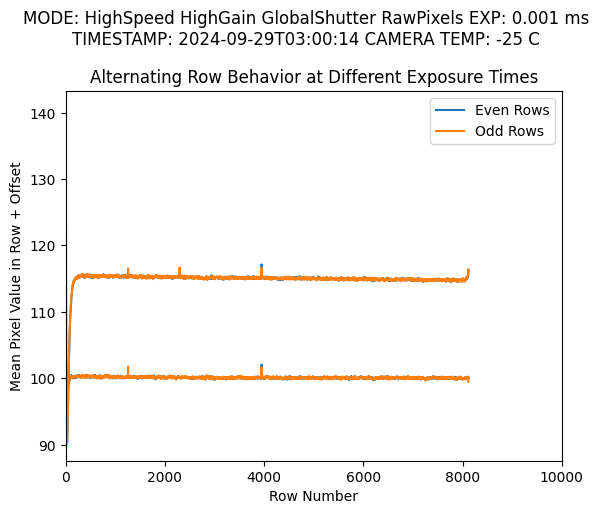

In [7]:
# See if there's any pattern in the bias frame pixel values every 4 rows.
# We think 4 rows are read out at a time, so this would be possible.
rows_mod_4_0 = np.mean(bias_stacks[0]["mean_img"][0::4], axis=1)
rows_mod_4_1 = np.mean(bias_stacks[0]["mean_img"][1::4], axis=1)
rows_mod_4_2 = np.mean(bias_stacks[0]["mean_img"][2::4], axis=1)
rows_mod_4_3 = np.mean(bias_stacks[0]["mean_img"][3::4], axis=1)
plt.plot(np.arange(0, 8120, 4), rows_mod_4_0, label='Row # Mod 4 = 0')
plt.plot(np.arange(1, 8120, 4), rows_mod_4_1, label='Row # Mod 4 = 1')
plt.plot(np.arange(2, 8120, 4), rows_mod_4_2, label='Row # Mod 4 = 2')
plt.plot(np.arange(3, 8120, 4), rows_mod_4_3, label='Row # Mod 4 = 3')
plt.xlabel('Row Number')
plt.ylabel('Mean Pixel Value in Row')
plt.ylim(bias_low, bias_high)
label_plot(bias_stacks[0])
plt.legend()
plt.title('Bias Frame Pixel Values Across Rows')
plt.show()

even_rows_1s = np.mean(bias_stacks[1]["mean_img"][::2], axis=1)
odd_rows_1s = np.mean(bias_stacks[1]["mean_img"][1::2], axis=1)
plt.plot(np.arange(0, 8120, 2), even_rows_bias, label='Bias Frame, Even Rows')
plt.plot(np.arange(0, 8120, 2), odd_rows_bias, label='Bias Frame, Odd Rows')
plt.plot(np.arange(0, 8120, 2), even_rows_1s, label='1s Frame, Even Rows')
plt.plot(np.arange(0, 8120, 2), odd_rows_1s, label='1s Frame, Odd Rows')
plt.xlabel('Row Number')
plt.ylabel('Mean Pixel Value in Row')
plt.ylim(bias_low, bias_high)
label_plot(bias_stacks[1])
plt.legend()
plt.title('Bias Frame and 1s Frame Pixel Values Across Rows')
plt.show()

color_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
color_orange = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
plt.plot(np.arange(0, 8120, 2), even_rows_bias, label='Even Rows', color=color_blue)
plt.plot(np.arange(0, 8120, 2), odd_rows_bias, label='Odd Rows', color=color_orange)
plt.plot(np.arange(0, 8120, 2), even_rows_1s + 15, color=color_blue)
plt.plot(np.arange(0, 8120, 2), odd_rows_1s + 15, color=color_orange)
plt.xlabel('Row Number')
plt.ylabel('Mean Pixel Value in Row + Offset')
# Have to adjust limits to make this look nice
# plt.ylim(200, 270)
plt.xlim(0, 10000)
label_plot(bias_stacks[0])
# Put label for bias as text on right
# plt.text(8200, 200, 'Bias Frame')
# plt.text(8200, 215, '1s Frame')
# plt.text(8200, 230, '5s Frame')
# plt.text(8200, 218, '30s Frame')
plt.title('Alternating Row Behavior at Different Exposure Times')
plt.legend()
plt.show()
